# Introduction to Bayesian Modeling with PyMC3
***
## 1. Mathematical Background
### 1.1 Bayes Theorem
#### Frequentist vs Bayesian
The essential difference between frequentist inference and Bayesian inference is the same as the difference between the two interpretations of what a “probability” means.

Frequentist inference is a method of statistical inference in which conclusions from data is obtained by emphasizing the frequency or proportion of the data.

Bayesian inference is a method of statistical inference in which Bayes’ theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

#### Bayesian Approach to Data Analysis
Assume that you have a sample of observations (y1,y2,y3,...yn) of a random variable $Y \sim f(y|\theta)$, 
where $\theta$ is a parameter for the distribution. Here we consider $\theta$
 as a random variable as well. Following Bayes Theorem (its continuous version) we can write:
 
 $$ f(\theta|y) = \frac{f(y|\theta)f(\theta)}{f(y)}$$
 
 <li>the function $f(y|\theta)$ is called likelihood</li>
 <li>the function $f(\theta)$ is called prior</li>
 <li>the function $f(y)$ is independent of $\theta$</li>
 
 Therefore,
 
  $$ f(\theta|y) \propto likelihood * prior$$

## 2. Case Study: Medical Insurance Claim Distribution

In [2]:
from scipy.stats import expon,gamma
from numpy.random import seed
import pymc3 as pm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import gamma

## Sample distribution

In [3]:
df = pd.read_csv('Projects/P3/Processed_data/full_clean_data.csv',index_col=0)

In [108]:
amount = df.loc[df.amount>0].amount.dropna()

In [109]:
amount.shape

(663443,)

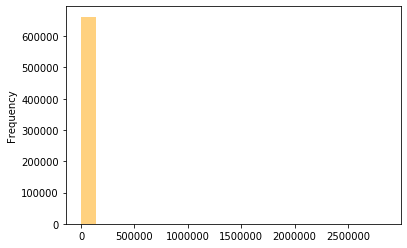

In [110]:
amount.plot.hist(bins=20,label='observed',alpha=0.5,color='orange')

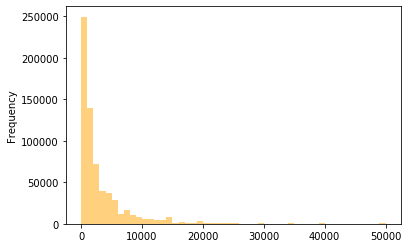

In [114]:
amount[amount<=50000].plot.hist(bins=50,label='observed',alpha=0.5,color='orange')

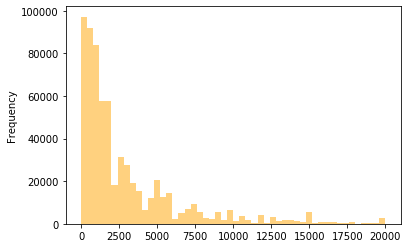

In [113]:
amount[amount<=20000].plot.hist(bins=50,label='observed',alpha=0.5,color='orange')

In [115]:
amount = amount.loc[amount<=50000]

## Exponential distribution

$f(x) = \lambda e^{-\lambda x}$ (x > 0)

In [116]:
mean = amount.mean() # mean = 1/lambda = scale
sd = amount.std()
round(mean,0),round(sd,0)

(3353.0, 4953.0)

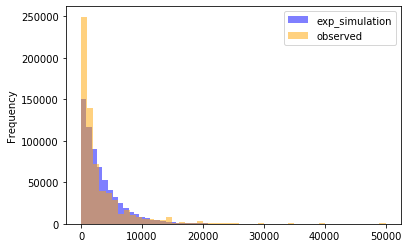

In [119]:
from numpy.random import exponential
exp = exponential(scale=mean,size=amount.shape[0])
plt.hist(exp, bins=50,label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=50,label='observed',alpha=0.5,color='orange')
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

In [120]:
# use normal distribution as prior guess of distribution
with pm.Model() as model:
    mu_ = pm.Normal('mu', mu = mean, sigma=mean) # prior
    y_obs = pm.Exponential('y_obs', lam = 1/mu_, observed=amount) # likelihood
    trace = pm.sample(draws=500, tune = 500,chains=2) # draw samples from the MCMC chain

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:25<00:00, 77.97draws/s]


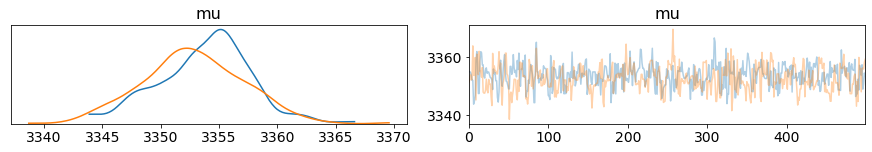

In [121]:
_ = pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c35743bd0>],
      dtype=object)

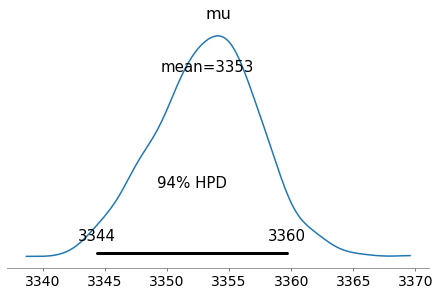

In [122]:
pm.plot_posterior(trace)

In [123]:
pm.summary(trace)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,3353.241971,4.113318,0.203206,3344.392755,3360.453376,414.933088,1.015045


## Gamma distribution simulation

$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},   x>0,   \Gamma(k) = (k-1)!$

$\mu = k\theta, \sigma^2 = k{\theta}^2$

$k= {\mu}^2/\sigma^2, \theta = \sigma^2/\mu$

In [170]:
# initial parameter of gamma distribution mean = k
k = (mean/sd)**2 # shape parameter, also called alpha
theta = sd**2/mean # scale parameter, also called 1/beta
k,theta, 1/theta

(0.45829689871364093, 7315.849054696805, 0.00013668953425959436)

In [146]:
gamma1 = gamma(shape=k, scale=theta,size=amount.shape[0])
dist = pd.DataFrame({})
dist['gamma'] = gamma1
gamma1 = dist['gamma'].loc[dist['gamma']<=50000]

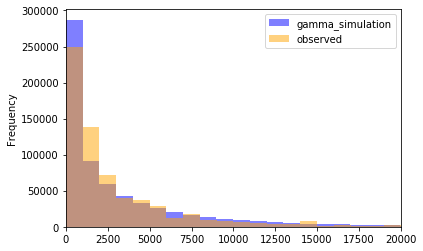

In [147]:

plt.hist(gamma1, bins=50,label='gamma_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=50,label='observed',alpha=0.5,color='orange')
plt.xlim(0,20000)
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

### Gamma distribution

In [127]:
# baysian optimization of parameter
with pm.Model() as model:
    
    alpha_ = pm.Exponential('alpha', k) # prior
    rate_ = pm.Exponential('rate',1/theta) # prior
    
    y_obs = pm.Gamma('y_obs', alpha=alpha_, beta=1/rate_, observed=amount) # likelihood
    trace_2 = pm.sample(draws=500, tune = 500) # traw 2000 traces from posterior population

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:40<00:00, 19.80draws/s]
The acceptance probability does not match the target. It is 0.8992237434953562, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946829695155285, but should be close to 0.8. Try to increase the number of tuning steps.


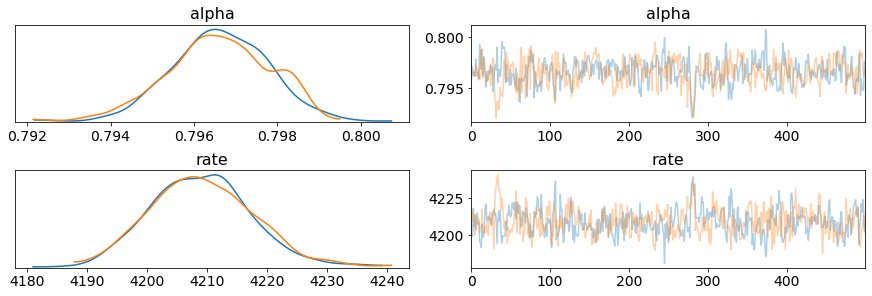

In [128]:
_ = pm.traceplot(trace_2)

In [129]:
pm.summary(trace_2)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.796576,0.001221,0.000063,0.794210,0.798813,297.834757,0.999490
rate,4209.067572,8.591753,0.453163,4192.712931,4225.973073,286.742487,0.999449


In [160]:
gamma2 = gamma(shape=0.7966, scale=4210,size=amount.shape[0])
dist = pd.DataFrame({})
dist['gamma2'] = gamma2
gamma2 = dist['gamma2'].loc[dist['gamma2']<=50000]

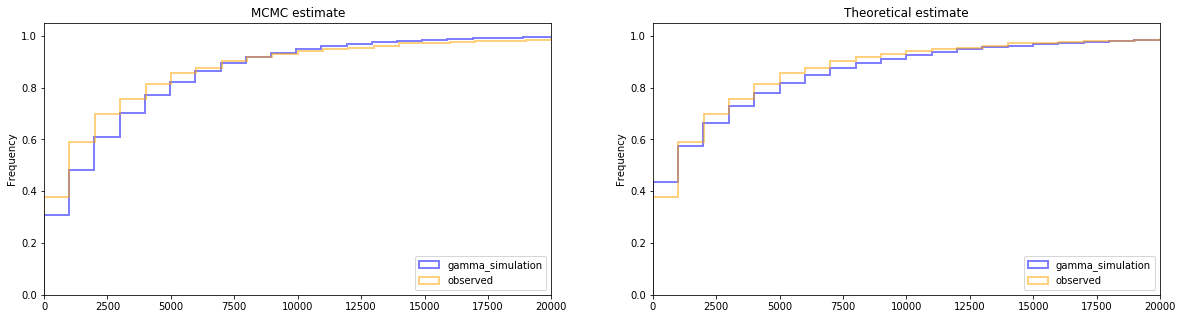

In [175]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax1.hist(gamma2, bins=50,label='gamma_simulation',alpha=0.5,color='blue',\
         density=True, cumulative=True,histtype='step',linewidth=2)
amount.plot.hist(bins=50,label='observed',alpha=0.5,color='orange',ax=ax1,\
                 density=True, cumulative=True,histtype='step',linewidth=2)
plt.title('MCMC estimate')
plt.xlim(0,20000)
plt.legend(loc=4)

ax2 = fig.add_subplot(122)
ax2.hist(gamma1, bins=50,label='gamma_simulation',alpha=0.5,color='blue',\
         density=True, cumulative=True,histtype='step',linewidth=2)
amount.plot.hist(bins=50,label='observed',alpha=0.5,color='orange',ax=ax2,\
                 density=True, cumulative=True,histtype='step',linewidth=2)
plt.title('Theoretical estimate')
plt.xlim(0,20000)
plt.legend(loc=4)

In [33]:
from scipy import stats

In [150]:
stats.ks_2samp(amount,gamma1) # theoretical

Ks_2sampResult(statistic=0.16785594549422594, pvalue=0.0)

In [155]:
stats.ks_2samp(amount,gamma2) # MCMC

Ks_2sampResult(statistic=0.10267564779893806, pvalue=0.0)